
  Memory set to 476.837 MiB by Python driver.

Scratch directory: /tmp/

*** tstart() called on cs003.hpc.nyu.edu
*** at Thu Nov  7 15:45:50 2024

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry AR         line   718 file /ext3/miniconda3/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    476 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: d2h
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  --

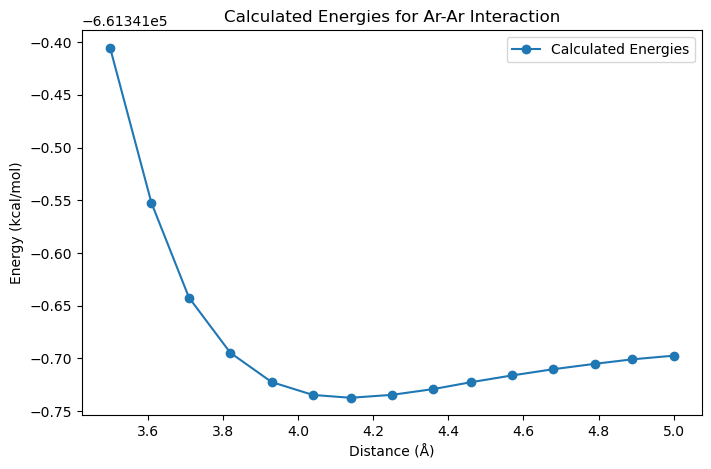

In [35]:
import numpy as np
import psi4
import matplotlib.pyplot as plt

# 设置内存
psi4.set_memory('500 MB')

# 定义距离范围并增加点
Rvals = np.linspace(3.5, 5.0, 15)  # 缩小距离范围，生成 15 个点
energies = []

# 计算每个距离的能量并保存到文件
with open("psi4_results.txt", "w") as f:
    f.write("Distance(Å) Energy(Hartree)\n")
    for R in Rvals:
        # 定义氩分子的几何结构
        ar2 = psi4.geometry(f"""
        0 1
        Ar
        --
        Ar 1 {R}
        """)
        
        # 计算能量
        try:
            energy = psi4.energy('ccsd(t)/cc-pvdz', molecule=ar2)
            energies.append(energy)
            f.write(f"{R:.2f} {energy}\n")  # 保存距离和能量到文件
            print(f"Distance: {R} Å, Energy: {energy} Hartree")
        except Exception as e:
            print(f"Energy calculation failed at distance {R} Å with error: {e}")
            energies.append(np.nan)  # 若计算失败，存储 NaN 以占位

# 读取文件中的数据
data = np.loadtxt("psi4_results.txt", skiprows=1)
Rvals = data[:, 0]
energies = data[:, 1]

# 将能量从 Hartree 转换为 kcal/mol，并输出转换后的数据
energies = energies * psi4.constants.hartree2kcalmol
print("Converted Energies (kcal/mol):", energies)

# 绘制计算点的折线图
plt.figure(figsize=(8, 5))
plt.plot(Rvals, energies, '-o', label="Calculated Energies")
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (kcal/mol)")
plt.title("Calculated Energies for Ar-Ar Interaction")
plt.legend()
# 保存图片至指定文件夹
plt.savefig("/scratch/hz3883/Week10-IntroElectronicStructure/Ar_Ar_Calculated_Energies.png")
print("Plot saved successfully.")

plt.show()


Fitted plot saved successfully.


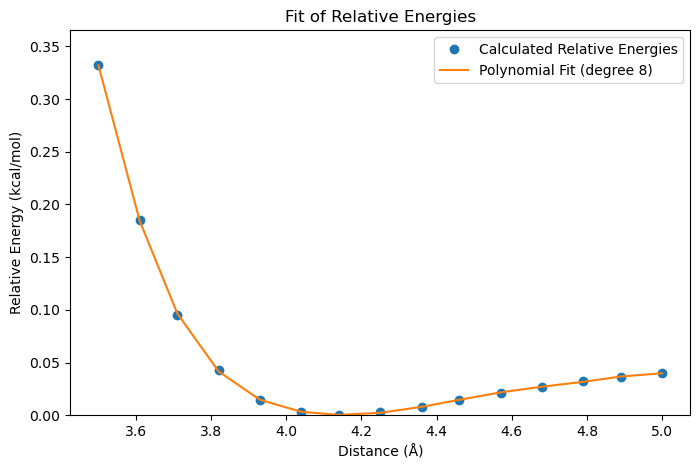

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# 使用生成的文件 psi4_results.txt
data_file = "psi4_results.txt"

# 读取数据
data = np.loadtxt(data_file, skiprows=1)
Rvals = data[:, 0]  # 距离列
energies = data[:, 1]  # 能量列（Hartree）

# 将能量从 Hartree 转换为 kcal/mol (1 Hartree = 627.5095 kcal/mol)
hartree_to_kcalmol = 627.5095
energies = energies * hartree_to_kcalmol

# 转换为相对能量，以最小能量为基准
energies_relative = energies - np.min(energies)

# 使用多项式拟合
degree = 8  # 多项式的阶数，可根据需要调整
coefficients = np.polyfit(Rvals, energies_relative, degree)
poly_fit = np.poly1d(coefficients)

# 使用拟合的多项式计算拟合曲线
fitted_energies = poly_fit(Rvals)

# 绘制原始数据点和多项式拟合曲线
plt.figure(figsize=(8, 5))
plt.plot(Rvals, energies_relative, 'o', label="Calculated Relative Energies")
plt.plot(Rvals, fitted_energies, '-', label=f"Polynomial Fit (degree {degree})")
plt.xlabel("Distance (Å)")
plt.ylabel("Relative Energy (kcal/mol)")

# 自动确定 y 轴的范围，以适应相对能量
y_min = min(min(energies_relative), min(fitted_energies)) * 0.9  # 扩展 10%
y_max = max(max(energies_relative), max(fitted_energies)) * 1.1  # 扩展 10%
plt.ylim(y_min, y_max)  # 根据数据动态设置 y 轴范围

plt.legend()
plt.title("Fit of Relative Energies")

# 保存拟合图像
plt.savefig("/scratch/hz3883/Week10-IntroElectronicStructure/Polynomial_Fit_Relative_Energies.png")
print("Fitted plot saved successfully.")

plt.show()


In [72]:
import psi4
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)
    
ar2_geometry = """
Ar
--
Ar 1 {0}
"""

Rvals = np.linspace(3.5, 6.0, 10)

psi4.set_options({'freeze_core': True})

ecp = {}

for R in Rvals:
    ar2 = psi4.geometry(ar2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ar2)
    
R_data = np.array(Rvals)
E_data = np.array([ecp[R] * psi4.constants.hartree2kcalmol for R in Rvals])


# Fit the data to the Lennard-Jones potential using curve fitting
popt, pcov = curve_fit(lj, R_data, E_data, p0=[3.0, 1.0])  # Initial guess for sigma and eps

sigma_fit, eps_fit = popt

# Print out the fitted parameters
print(f"Fitted sigma: {sigma_fit:.3f} Å")
print(f"Fitted epsilon: {eps_fit:.3f} kcal/mol")

# Plot the original data and the fitted curve
R_fine = np.linspace(min(R_data), max(R_data), 100)  # Fine R values for smooth plot
E_fitted = lj(R_fine, *popt)



Scratch directory: /tmp/

  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  // ManyBody Setup: N-Body Levels [1, 2]//
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//

        Number of 1-body computations:     2
        Number of 2-body computations:     1

    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.7a1.dev44 

                         Git: Rev {master} 2792bff 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. 

In [1]:
import os
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(R_data, E_data, color='red', label='Data', zorder=5)
plt.plot(R_fine, E_fitted, color='blue', label=f"Fitted LJ potential\n($\\sigma$={sigma_fit:.3f}, $\\epsilon$={eps_fit:.3f})")
plt.xlabel('Interatomic Distance R (Å)')
plt.ylabel('Interaction Energy E (kcal/mol)')
plt.title('Counterpoise-Corrected Interaction Energy vs Distance')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('/home/hz3883/Counterpoise-Corrected Interaction Energy vs Distance.png')

# # Optionally, print results to the console only, not output.dat
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print(f"            {R:3.1f}                        {e:1.6f}")


NameError: name 'plt' is not defined